In [1]:
import os
import shutil
import sys
import copy
import json
import random
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score
from lifelines.utils import concordance_index
from scipy.stats import pearsonr
import pickle 

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(2)  
np.random.seed(3)
from prettytable import PrettyTable
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.style.use("ggplot")

print(os.path.abspath('.'))
import warnings
warnings.filterwarnings("ignore")

from DeepPurpose import utils, models, dataset
from DeepPurpose.models import *

/home/gdp/data/DeepPurpose0


In [2]:
class Original_add_VAEdataset(Dataset):
	def __init__(self, df_data, **config):
		self.indexs = df_data.index.values
		self.label = df_data.Label.values
		self.df_data = df_data
		self.config = config

	def __len__(self):
		return len(self.indexs)

	def __getitem__(self, index):
		v_d = self.df_data.iloc[index]['drug_encoding']
		#v_d = drug_2_embed(v_d)
		v_p = self.df_data.iloc[index]['target_encoding']
		#v_p = protein_2_embed(v_p)
		label = self.label[index]
        
		v_d_vae = self.df_data.iloc[index]['drug_vae']
		v_p_vae = self.df_data.iloc[index]['target_vae']        
		return v_d, v_p, label, v_d_vae, v_p_vae

In [3]:
#DTC
drug_encoding, target_encoding = 'Daylight', 'AAC'

DTC_sub=pd.read_csv('VAE_data/df_DTC_undrugs_targets.csv')
Smile = DTC_sub['SMILES'].values
Target = DTC_sub['Target_Sequence'].values
y = DTC_sub['Label'].values
train, val, test = utils.data_process(Smile, Target, y,
                                drug_encoding, target_encoding, 
                                split_method='train_full',frac=[0.8,0.1,0.1],
                                random_seed = 1)

print('DTC subset Done!----------------------------------')
#DB
Smile2 = np.load("VAE_data/DB_smiles.npy", allow_pickle=True)
Target2 = np.load("VAE_data/DB_targets.npy", allow_pickle=True)
y2 = np.load("VAE_data/DB_y.npy", allow_pickle=True)
train2, val2, test2 = utils.data_process(Smile2, Target2, y2,
                                drug_encoding, target_encoding, 
                                split_method='train_full',frac=[0.8,0.1,0.1],
                                random_seed = 1)
print('DB Done!-----------------------------------')

in total: 51863 drug-target pairs
encoding drug...
unique drugs: 6677
drug encoding finished...
encoding protein...
unique target sequence: 766
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.					 Calculate your time by the unique target sequence #, instead of the entire dataset.
protein encoding finished...
splitting dataset...
Done.
DTC subset Done!----------------------------------
in total: 66434 drug-target pairs
encoding drug...
unique drugs: 10661
drug encoding finished...
encoding protein...
unique target sequence: 1413
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.					 Calculate your time by the unique target sequence #, instead of the entire dataset.
protein encoding finished...
splitting dataset...
Done.
DB Done!-----------------------------------


In [4]:
#########################################################

In [5]:
#Dtc
unique3 = torch.load('features_drug_dtc_dtcdb_vae.pt').numpy() 
unique_dict3 = dict(zip(train['SMILES'].unique(), unique3))
train['drug_vae'] = [unique_dict3[i] for i in train['SMILES']]

In [6]:
#DB
unique3_db = torch.load('features_drug_db_dtcdb_vae.pt').numpy() 
unique_dict3_db = dict(zip(train2['SMILES'].unique(), unique3_db))
train2['drug_vae'] = [unique_dict3_db[i] for i in train2['SMILES']]

In [7]:
#target
AA3 = torch.load('features_target_dtc_dtcdb_vae.pt').numpy() 
AA_dict3 = dict(zip(train['Target Sequence'].unique(), AA3))
train['target_vae'] = [AA_dict3[i] for i in train['Target Sequence']]

In [8]:
AA3_dtc = torch.load('features_target_db_dtcdb_vae.pt').numpy() 
AA_dict3_dtc = dict(zip(train2['Target Sequence'].unique(), AA3_dtc))
train2['target_vae'] = [AA_dict3_dtc[i] for i in train2['Target Sequence']]

In [9]:
#########################################################

In [10]:
class DNN_add_VAE(nn.Sequential):
	def __init__(self, model_drug, model_protein, input_dim_vae, **config):
		super(DNN_add_VAE, self).__init__()
		self.input_dim_vae = input_dim_vae    #VAE模型中drug与target的latent_feature_dim       
		self.input_dim_drug = 256
		self.input_dim_protein = 256
		self.dropout = nn.Dropout(0.1)
		self.hidden_dims = config['cls_hidden_dims']
		layer_size = len(self.hidden_dims) + 1
		dims = [self.input_dim_drug + self.input_dim_protein + self.input_dim_vae + self.input_dim_vae] + self.hidden_dims + [1]
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])
        
		self.model_drug = model_drug
		self.model_protein = model_protein

		self.fc1 = nn.Linear(self.input_dim_vae, self.input_dim_vae)
        
		self.fc2 = nn.Linear(self.input_dim_vae, self.input_dim_vae)
        
	def forward(self, v_D, v_P, v_d_vae, v_p_vae):
		# each encoding and cat
		v_D = self.model_drug(v_D)
		v_d_vae = self.fc1(v_d_vae)
		v_D2 = torch.cat((v_D, v_d_vae), 1)
		v_P = self.model_protein(v_P)
		v_p_vae = self.fc2(v_p_vae)
		v_P2 = torch.cat((v_P, v_p_vae), 1)
		# concatenate and classify
		v_f = torch.cat((v_D2, v_P2), 1)
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))        
		return v_f    

In [11]:
class Pipeline:

	def __init__(self, model_drug, model_protein, input_dim_vae, **config):
                 
		self.classifier = DNN_add_VAE(model_drug, model_protein, input_dim_vae, **config)
		self.config = config          
		self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		self.result_folder = config['result_folder']
		if not os.path.exists(self.result_folder):
			os.mkdir(self.result_folder)

	def test(self, validation_generator, classifier):
		y_pred = []
		y_label = []
		classifier.eval()
		for i, (v_d, v_p, label, v_d_vae, v_p_vae) in enumerate(validation_generator):  
			if self.config['drug_encoding'] == "MPNN" or self.config['drug_encoding'] == 'Transformer':
				v_d = v_d
			else:
				v_d = v_d.float().to(self.device) 
			v_p = v_p.float().to(self.device)
			v_d_vae = v_d_vae.float().to(self.device) 
			v_p_vae = v_p_vae.float().to(self.device)                

			score = self.classifier(v_d, v_p, v_d_vae, v_p_vae)                
			logits = torch.squeeze(score).detach().cpu().numpy()
			label_ids = label.to('cpu').numpy()
			y_label = y_label + label_ids.flatten().tolist()
			y_pred = y_pred + logits.flatten().tolist()
			#print(y_label)
		classifier.train()
		return mean_squared_error(y_label, y_pred), pearsonr(y_label, y_pred)[0], pearsonr(y_label, y_pred)[1], concordance_index(y_label, y_pred), y_pred

	def train(self, train, val, test, verbose = True):
		lr = self.config['LR']
		train_epoch = self.config['train_epoch']
		loss_history = []
		loss_val_history = []

		self.classifier = self.classifier.to(self.device)        
		opt = torch.optim.Adam(self.classifier.parameters(),lr = lr, weight_decay=0.0001)

		valid_metric_record = []
		valid_metric_header = ["# epoch"] 
		valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
		table = PrettyTable(valid_metric_header)
		float2str = lambda x:'%0.4f'%x
        
		print('--- Data Preparation ---')
		params = {'batch_size': self.config['batch_size'], 'shuffle': True, 'drop_last': False}
		if (self.config['drug_encoding'] == "MPNN"):
			params['collate_fn'] = mpnn_collate_func
		training_generator = DataLoader(Original_add_VAEdataset(train, **self.config), **params)
		validation_generator = DataLoader(Original_add_VAEdataset(val, **self.config), **params)
		test_generator = DataLoader(Original_add_VAEdataset(test, **self.config), **params)        

		print("Let's use " + str(torch.cuda.device_count()) + " GPU!")
		print('--- Go for Training ---')
		t_start = time() 
		for epo in range(train_epoch):
			for i, (v_d, v_p, label, v_d_vae, v_p_vae) in enumerate(training_generator):
				if self.config['drug_encoding'] == "MPNN" or self.config['drug_encoding'] == 'Transformer':
					v_d = v_d
				else:
					v_d = v_d.float().to(self.device)
				v_p = v_p.float().to(self.device)
				v_d_vae = v_d_vae.float().to(self.device) 
				v_p_vae = v_p_vae.float().to(self.device)                
                
				score = self.classifier(v_d, v_p, v_d_vae, v_p_vae)    
				label = Variable(torch.from_numpy(np.array(label)).float()).to(self.device)
				#print(score)
				loss_fct = torch.nn.MSELoss()
				n = torch.squeeze(score, 1)
				loss = loss_fct(n, label)
				loss_history.append(loss.item())

				opt.zero_grad()
				loss.backward()
				opt.step()

				if (i % 100 == 0):
					t_now = time()
					print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + \
							' with loss ' + str(loss.cpu().detach().numpy())[:7] +\
							". Total time " + str(int(t_now - t_start)/3600)[:7] + " hours") 

			#### validate, select the best model up to now 
			with torch.no_grad():
					### regression: MSE, Pearson Correlation, with p-value, Concordance Index  
				mse, r2, p_val, CI, logits = self.test(validation_generator, self.classifier)
				lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))
				valid_metric_record.append(lst)
				print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
					+ str(r2)[:7] + ' with p-value: ' + str(p_val)[:7] +' , Concordance Index: '+str(CI)[:7])
				#### predict dtc, select the best epoch
				mse2, r22, p_val2, CI2, logits2 = self.test(test_generator, self.classifier)
				lst2 = ["epoch " + str(epo)] + list(map(float2str,[mse2, r22, p_val2, CI2]))
				valid_metric_record.append(lst2)
				print('test at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse2)[:7] + ' , Pearson Correlation: '\
					+ str(r22)[:7] + ' with p-value: ' + str(p_val2)[:7] +' , Concordance Index: '+str(CI2)[:7])                
                           
			table.add_row(lst)
			loss_val_history.append(mse)
                       

		#### after training 
		prettytable_file = os.path.join(self.result_folder, "valid_markdowntable.txt")
		with open(prettytable_file, 'w') as fp:
			fp.write(table.get_string())

		### 2. learning curve 
		fontsize = 16
		iter_num = list(range(1,len(loss_history)+1))
		plt.figure(1)
		plt.plot(iter_num, loss_history, "bo-")
		plt.xlabel("iteration", fontsize = fontsize)
		plt.ylabel("loss value", fontsize = fontsize)
        
		fontsize = 16
		iter_num = list(range(1,len(loss_val_history)+1))
		plt.figure(2)
		plt.plot(iter_num, loss_val_history, "mo-")
		plt.xlabel("epoch", fontsize = fontsize)
		plt.ylabel("val_loss", fontsize = fontsize)
        
		pkl_file = os.path.join(self.result_folder, "loss_curve_iter.pkl")
		with open(pkl_file, 'wb') as pck:
			pickle.dump(loss_history, pck)
		print('--- Training Finished ---')        

In [12]:
val = train2.sample(frac = 0.1, replace = False, random_state = 1)
test = train

In [13]:
config = utils.generate_config(drug_encoding ='Daylight', 
                         target_encoding = 'AAC', 
                         input_dim_drug = 2048,
                         hidden_dim_drug = 256,
                         mlp_hidden_dims_drug = [1024, 256, 64],
                         input_dim_protein = 8420,
                         hidden_dim_protein = 256,
                         mlp_hidden_dims_target = [1024, 256, 64],
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 100, 
                         LR = 0.001, 
                         batch_size = 512)

In [14]:
model_drug = MLP(config['input_dim_drug'], config['hidden_dim_drug'], config['mlp_hidden_dims_drug'])
model_protein = MLP(config['input_dim_protein'], config['hidden_dim_protein'], config['mlp_hidden_dims_target'])
#model_protein = CNN('protein', **config)
#model_protein = CNN('drug', **config)

--- Data Preparation ---
Let's use 1 GPU!
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 34.9855. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 1.29155. Total time 0.01111 hours
Validation at Epoch 1 , MSE: 0.98647 , Pearson Correlation: 0.65946 with p-value: 0.0 , Concordance Index: 0.77805
test at Epoch 1 , MSE: 0.94472 , Pearson Correlation: 0.62181 with p-value: 0.0 , Concordance Index: 0.76469
Training at Epoch 2 iteration 0 with loss 1.07226. Total time 0.02861 hours
Training at Epoch 2 iteration 100 with loss 0.95943. Total time 0.03972 hours
Validation at Epoch 2 , MSE: 0.88285 , Pearson Correlation: 0.70197 with p-value: 0.0 , Concordance Index: 0.79298
test at Epoch 2 , MSE: 0.88164 , Pearson Correlation: 0.66090 with p-value: 0.0 , Concordance Index: 0.77930
Training at Epoch 3 iteration 0 with loss 0.81431. Total time 0.05638 hours
Training at Epoch 3 iteration 100 with loss 0.90694. Total time 0.06777 hours
Validation at Epoch 3 , MSE:

Validation at Epoch 22 , MSE: 0.56977 , Pearson Correlation: 0.83812 with p-value: 0.0 , Concordance Index: 0.85989
test at Epoch 22 , MSE: 0.65194 , Pearson Correlation: 0.76945 with p-value: 0.0 , Concordance Index: 0.82752
Training at Epoch 23 iteration 0 with loss 0.54063. Total time 0.63222 hours
Training at Epoch 23 iteration 100 with loss 0.61323. Total time 0.64388 hours
Validation at Epoch 23 , MSE: 0.51346 , Pearson Correlation: 0.84644 with p-value: 0.0 , Concordance Index: 0.86459
test at Epoch 23 , MSE: 0.59296 , Pearson Correlation: 0.78637 with p-value: 0.0 , Concordance Index: 0.83274
Training at Epoch 24 iteration 0 with loss 0.47314. Total time 0.66111 hours
Training at Epoch 24 iteration 100 with loss 0.54213. Total time 0.67277 hours
Validation at Epoch 24 , MSE: 0.50123 , Pearson Correlation: 0.85078 with p-value: 0.0 , Concordance Index: 0.86884
test at Epoch 24 , MSE: 0.58320 , Pearson Correlation: 0.78992 with p-value: 0.0 , Concordance Index: 0.83609
Training a

Training at Epoch 44 iteration 0 with loss 0.37356. Total time 1.23805 hours
Training at Epoch 44 iteration 100 with loss 0.52159. Total time 1.24972 hours
Validation at Epoch 44 , MSE: 0.44005 , Pearson Correlation: 0.88433 with p-value: 0.0 , Concordance Index: 0.88891
test at Epoch 44 , MSE: 0.69766 , Pearson Correlation: 0.80336 with p-value: 0.0 , Concordance Index: 0.84909
Training at Epoch 45 iteration 0 with loss 0.45380. Total time 1.26694 hours
Training at Epoch 45 iteration 100 with loss 0.43647. Total time 1.27888 hours
Validation at Epoch 45 , MSE: 0.38981 , Pearson Correlation: 0.88089 with p-value: 0.0 , Concordance Index: 0.88839
test at Epoch 45 , MSE: 0.55151 , Pearson Correlation: 0.80951 with p-value: 0.0 , Concordance Index: 0.85068
Training at Epoch 46 iteration 0 with loss 0.36869. Total time 1.29638 hours
Training at Epoch 46 iteration 100 with loss 0.45780. Total time 1.30805 hours
Validation at Epoch 46 , MSE: 0.37822 , Pearson Correlation: 0.88453 with p-valu

test at Epoch 65 , MSE: 0.52890 , Pearson Correlation: 0.81013 with p-value: 0.0 , Concordance Index: 0.85493
Training at Epoch 66 iteration 0 with loss 0.31579. Total time 1.87388 hours
Training at Epoch 66 iteration 100 with loss 0.35918. Total time 1.88555 hours
Validation at Epoch 66 , MSE: 0.33981 , Pearson Correlation: 0.89761 with p-value: 0.0 , Concordance Index: 0.90172
test at Epoch 66 , MSE: 0.58039 , Pearson Correlation: 0.81027 with p-value: 0.0 , Concordance Index: 0.85447
Training at Epoch 67 iteration 0 with loss 0.42125. Total time 1.90305 hours
Training at Epoch 67 iteration 100 with loss 0.43014. Total time 1.91472 hours
Validation at Epoch 67 , MSE: 0.34224 , Pearson Correlation: 0.89632 with p-value: 0.0 , Concordance Index: 0.89943
test at Epoch 67 , MSE: 0.54781 , Pearson Correlation: 0.80879 with p-value: 0.0 , Concordance Index: 0.85472
Training at Epoch 68 iteration 0 with loss 0.38777. Total time 1.93222 hours
Training at Epoch 68 iteration 100 with loss 0.44

Training at Epoch 87 iteration 100 with loss 0.37518. Total time 2.49277 hours
Validation at Epoch 87 , MSE: 0.30917 , Pearson Correlation: 0.91008 with p-value: 0.0 , Concordance Index: 0.91001
test at Epoch 87 , MSE: 0.53201 , Pearson Correlation: 0.82427 with p-value: 0.0 , Concordance Index: 0.86336
Training at Epoch 88 iteration 0 with loss 0.32469. Total time 2.51027 hours
Training at Epoch 88 iteration 100 with loss 0.34348. Total time 2.52194 hours
Validation at Epoch 88 , MSE: 0.30602 , Pearson Correlation: 0.90765 with p-value: 0.0 , Concordance Index: 0.91033
test at Epoch 88 , MSE: 0.50094 , Pearson Correlation: 0.82754 with p-value: 0.0 , Concordance Index: 0.86554
Training at Epoch 89 iteration 0 with loss 0.29524. Total time 2.53944 hours
Training at Epoch 89 iteration 100 with loss 0.40250. Total time 2.55111 hours
Validation at Epoch 89 , MSE: 0.31221 , Pearson Correlation: 0.90589 with p-value: 0.0 , Concordance Index: 0.90796
test at Epoch 89 , MSE: 0.56825 , Pearson

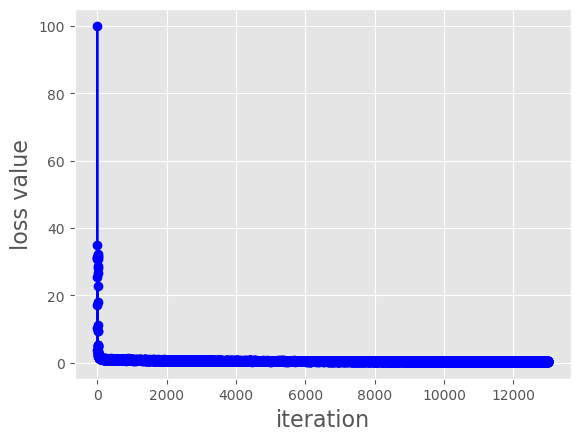

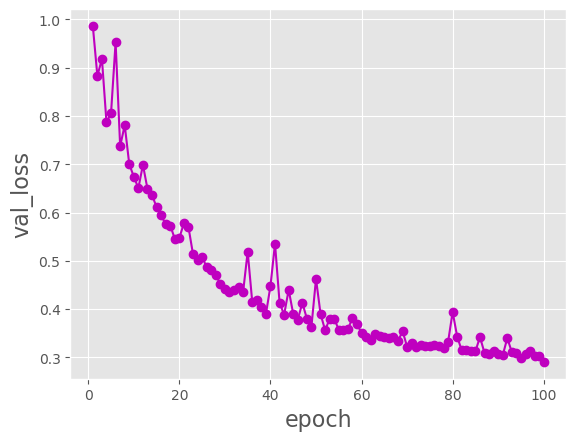

In [15]:
model = Pipeline(model_drug, model_protein, 10, **config)
model.train(train2, val, test)

In [ ]:
##下面这些继续训练的不用，前期用来看效果用的，备份。

In [25]:
torch.save(model.classifier.state_dict(), 'overfit_day_aac_db_dtc_100_model.pt')
save_dict('./', model.config)

In [22]:
#继续训练--------------------------------------
config = utils.generate_config(drug_encoding ='Daylight', 
                         target_encoding = 'AAC', 
                         input_dim_drug = 2048,
                         hidden_dim_drug = 256,
                         mlp_hidden_dims_drug = [1024, 256, 64],
                         input_dim_protein = 8420,
                         hidden_dim_protein = 256,
                         mlp_hidden_dims_target = [1024, 256, 64],
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 50, 
                         LR = 0.001, 
                         batch_size = 512)

In [23]:
model_drug = MLP(config['input_dim_drug'], config['hidden_dim_drug'], config['mlp_hidden_dims_drug'])
model_protein = MLP(config['input_dim_protein'], config['hidden_dim_protein'], config['mlp_hidden_dims_target'])

--- Data Preparation ---
Let's use 1 GPU!
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.31006. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.25991. Total time 0.01055 hours
Validation at Epoch 1 , MSE: 0.26651 , Pearson Correlation: 0.92079 with p-value: 0.0 , Concordance Index: 0.92381
test at Epoch 1 , MSE: 0.49553 , Pearson Correlation: 0.83621 with p-value: 0.0 , Concordance Index: 0.87422
Training at Epoch 2 iteration 0 with loss 0.19934. Total time 0.02611 hours
Training at Epoch 2 iteration 100 with loss 0.24401. Total time 0.03694 hours
Validation at Epoch 2 , MSE: 0.28410 , Pearson Correlation: 0.91793 with p-value: 0.0 , Concordance Index: 0.92283
test at Epoch 2 , MSE: 0.49133 , Pearson Correlation: 0.82565 with p-value: 0.0 , Concordance Index: 0.86874
Training at Epoch 3 iteration 0 with loss 0.26911. Total time 0.05277 hours
Training at Epoch 3 iteration 100 with loss 0.31054. Total time 0.06361 hours
Validation at Epoch 3 , MSE:

Validation at Epoch 22 , MSE: 0.26285 , Pearson Correlation: 0.92134 with p-value: 0.0 , Concordance Index: 0.92487
test at Epoch 22 , MSE: 0.49377 , Pearson Correlation: 0.83497 with p-value: 0.0 , Concordance Index: 0.87230
Training at Epoch 23 iteration 0 with loss 0.28499. Total time 0.57222 hours
Training at Epoch 23 iteration 100 with loss 0.32638. Total time 0.5825 hours
Validation at Epoch 23 , MSE: 0.26545 , Pearson Correlation: 0.92038 with p-value: 0.0 , Concordance Index: 0.92512
test at Epoch 23 , MSE: 0.48684 , Pearson Correlation: 0.83474 with p-value: 0.0 , Concordance Index: 0.87414
Training at Epoch 24 iteration 0 with loss 0.28417. Total time 0.59777 hours
Training at Epoch 24 iteration 100 with loss 0.27583. Total time 0.60916 hours
Validation at Epoch 24 , MSE: 0.25955 , Pearson Correlation: 0.92276 with p-value: 0.0 , Concordance Index: 0.92562
test at Epoch 24 , MSE: 0.47231 , Pearson Correlation: 0.83596 with p-value: 0.0 , Concordance Index: 0.87488
Training at

Training at Epoch 44 iteration 0 with loss 0.25404. Total time 1.12055 hours
Training at Epoch 44 iteration 100 with loss 0.25714. Total time 1.13111 hours
Validation at Epoch 44 , MSE: 0.25489 , Pearson Correlation: 0.92390 with p-value: 0.0 , Concordance Index: 0.92625
test at Epoch 44 , MSE: 0.50386 , Pearson Correlation: 0.83252 with p-value: 0.0 , Concordance Index: 0.87412
Training at Epoch 45 iteration 0 with loss 0.30136. Total time 1.14666 hours
Training at Epoch 45 iteration 100 with loss 0.30725. Total time 1.15694 hours
Validation at Epoch 45 , MSE: 0.25731 , Pearson Correlation: 0.92300 with p-value: 0.0 , Concordance Index: 0.92682
test at Epoch 45 , MSE: 0.48014 , Pearson Correlation: 0.83606 with p-value: 0.0 , Concordance Index: 0.87276
Training at Epoch 46 iteration 0 with loss 0.25181. Total time 1.1725 hours
Training at Epoch 46 iteration 100 with loss 0.31991. Total time 1.18277 hours
Validation at Epoch 46 , MSE: 0.25948 , Pearson Correlation: 0.92251 with p-value

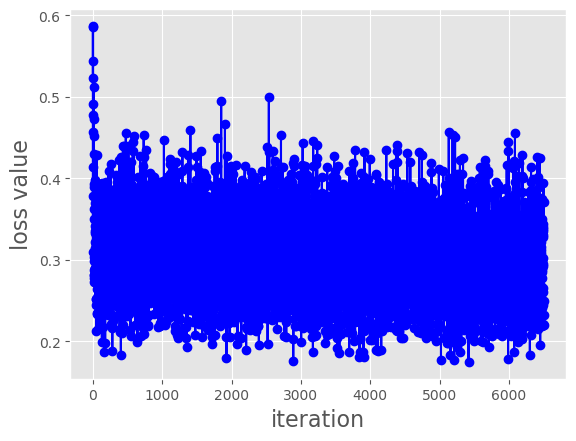

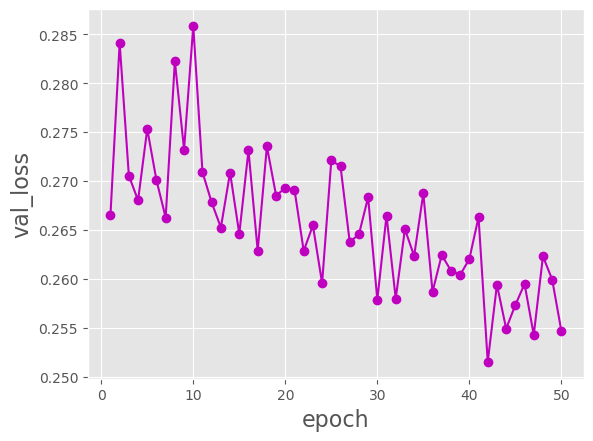

In [24]:
model = Pipeline(model_drug, model_protein, 10, **config)
state_dict = torch.load('overfit_day_aac_db_dtc_100_model.pt')
model.classifier.load_state_dict(state_dict)
model.train(train2, val, test)